# Object Detection


## Install Dependencies

In [1]:
import sys
!{sys.executable} -m pip install -r requirements.txt

## Setup


In [3]:
#@title Imports and function definitions

# For running inference on the TF-Hub module.
import tensorflow as tf

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

# Print Tensorflow version
print(f'Tensorflow Version {tf.__version__}')

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

Tensorflow Version 2.3.1
The following GPU devices are available: 


## Example use

### Helper functions for downloading images and for visualization.

Visualization code adapted from [TF object detection API](https://github.com/tensorflow/models/blob/master/research/object_detection/utils/visualization_utils.py) for the simplest required functionality.

In [4]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

## Apply module

Load a public image from Open Images v4, save locally, and display.

In [5]:
image_path = "images/Naxos_Taverna.jpg"

Pick an object detection module and apply on the downloaded image. Modules:
* **FasterRCNN+InceptionResNet V2**: high accuracy,
* **ssd+mobilenet V2**: small and fast.

In [6]:
model_dir = 'models/openimages_v4_ssd_mobilenet_v2_1'
saved_model = tf.saved_model.load(model_dir)
model = saved_model.signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [7]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [9]:
def run_detector(detector, path):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

  display_image(image_with_boxes)

Found 100 objects.
Inference time:  6.416542291641235
Font not found, using default font.


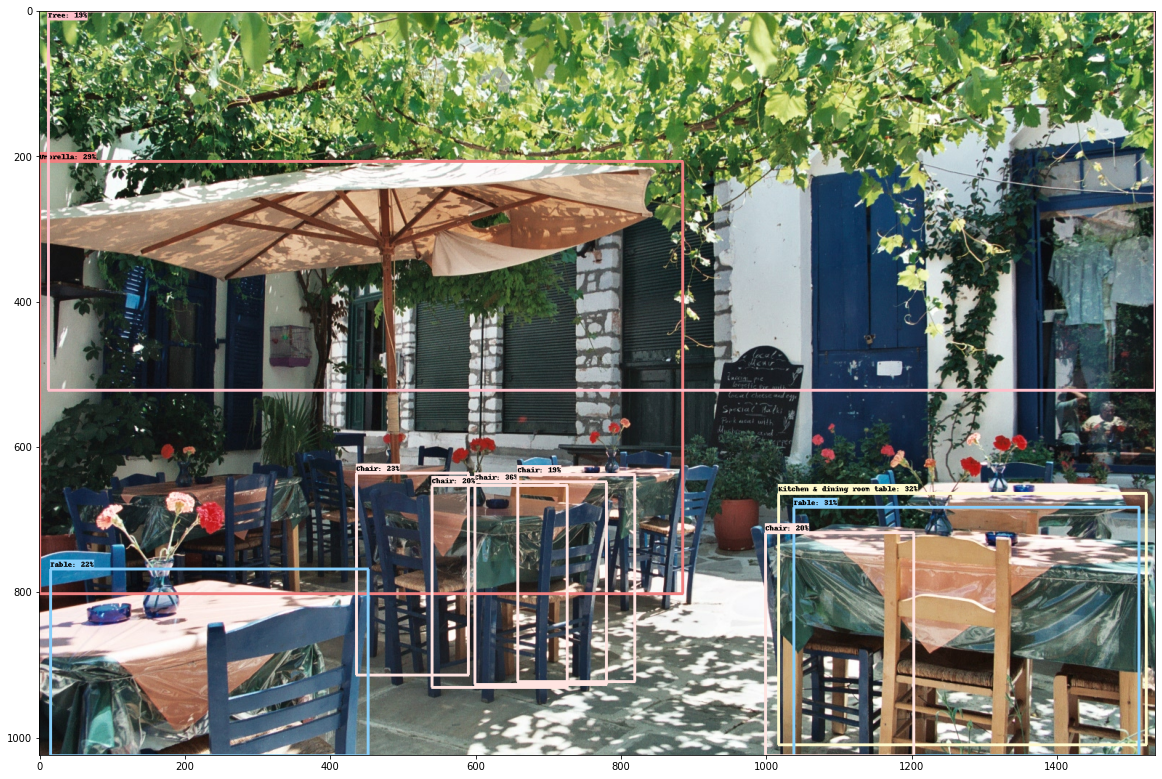

In [11]:
run_detector(model, image_path)

In [12]:
import numpy as np
import tensorflow as tf
import base64
import io

from PIL import Image

model_dir = 'models/openimages_v4_ssd_mobilenet_v2_1'
saved_model = tf.saved_model.load(model_dir)
detector = saved_model.signatures['default']


def predict(body):
    base64img = body.get('image')
    img_bytes = base64.decodebytes(base64img.encode())
    detections = detect(img_bytes)
    cleaned = clean_detections(detections)
    
    return { 'detections': cleaned }


def detect(img):    
    image = tf.image.decode_jpeg(img, channels=3)
    converted_img  = tf.image.convert_image_dtype(image, tf.float32)[tf.newaxis, ...]
    result = detector(converted_img)
    num_detections = len(result["detection_scores"])
    
    output_dict = {key:value.numpy().tolist() for key, value in result.items()}
    output_dict['num_detections'] = num_detections
    
    return output_dict


def clean_detections(detections):
    cleaned = []
    num_detections = detections['num_detections']

    for i in range(0, num_detections):
        d = {
            'box': {
                'yMin': detections['detection_boxes'][i][0],
                'xMin': detections['detection_boxes'][i][1],
                'yMax': detections['detection_boxes'][i][2],
                'xMax': detections['detection_boxes'][i][3]
            },
            'class': detections['detection_class_entities'][i].decode('utf-8'),
            'label': detections['detection_class_entities'][i].decode('utf-8'),
            'score': detections['detection_scores'][i],
        }
        cleaned.append(d)
    return cleaned



In [69]:
import json

def meh(detector, path):
    img = load_img(path)
    
    converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    start_time = time.time()
    result = detector(converted_img)
    end_time = time.time()

    return result
    num_detections = len(result["detection_scores"])
    
    output_dict = {key:value.numpy().tolist() for key,value in result.items()}
    output_dict['num_detections'] = num_detections
    
    return output_dict

x = meh(model, image_path)



In [90]:

y = {key:value for key,value in x.items()}
type(y['detection_scores'][0].numpy())

# type(y['detection_scores'][0])

# help(y['detection_scores'][0])

numpy.float32

In [81]:
detections = detect(model, image_path)
detections

TypeError: detect() takes 1 positional argument but 2 were given

In [36]:
detections_dict = clean_detections(detections)

In [46]:
import json
type(detections_dict[0]['box']['yMin'].item())
# json.dumps(detections_dict[0]['box']


float

In [49]:
x = 0.1
x.numpy()



AttributeError: 'float' object has no attribute 'numpy'

In [28]:
from prediction import predict, detect


# with open('requests/request-1.json') as json_file:
#     data = json.load(json_file)

# data
# predict(data)
img = tf.io.read_file(image_path)
detect(img)


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

In [ ]:
import base64

from PIL import Image

base64img = open('images/Naxos_Taverna.base64', "r").read()
img_bytes = base64.decodebytes(base64img.encode())
img2 = tf.image.decode_jpeg(img_bytes, channels=3)
img2



In [ ]:
from prediction import predict


In [ ]:
predict({'image': base64img})

### More images
Perform inference on some additional images with time tracking.


In [ ]:
image_paths = [
    'images/1024px-Biblioteca_Maimónides,_Campus_Universitario_de_Rabanales_007.jpg',
    'images/image1.jpg',
    'images/image2.jpg',
    'images/Naxos_Taverna.jpg',
    'images/The_Coleoptera_of_the_British_islands_(Plate_125)_(8592917784).jpg',
    'images/The_smaller_British_birds_(8053836633).jpg'
  ]

def detect_img(image_path):
  start_time = time.time()
#   image_path = download_and_resize_image(image_url, 640, 480)
  run_detector(model, image_path)
  end_time = time.time()
  print("Inference time:",end_time-start_time)

In [ ]:
detect_img(image_paths[0])

In [ ]:
detect_img(image_paths[1])

In [ ]:
detect_img(image_paths[2])

In [ ]:
detect_img(image_paths[3])

In [ ]:
detect_img(image_paths[4])